In [1]:
import sys
sys.path.append("../")

from torch import nn
from data_utils import load_mnist, load_usps
from models import DomainAdaptationNetwork, ProjectorNetwork

import torch
from torch.nn import functional as F
import numpy as np
from train import train_domain_adaptation
from utils import test_network, plot_target_cross_domain_swapping, plot_tsne

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-4q86sha0 because the default path (/home/david.bertoin/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
torch.manual_seed(0)
import numpy as np
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_space_dim, conv_feat_size, nb_channels=3):
        super(Decoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.conv_feat_size = conv_feat_size

        self.deco_dense = nn.Sequential(
            nn.Linear(in_features=latent_space_dim, out_features=1024),
            nn.ReLU(True),
            nn.Linear(in_features=1024, out_features=np.prod(self.conv_feat_size)),
            nn.ReLU(True),
        )

        self.deco_fetures = nn.Sequential(
            nn.Conv2d(in_channels=self.conv_feat_size[0], out_channels=75, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=75, out_channels=50, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=50, out_channels=1, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, z_task, z_spe):
        z = torch.cat([z_task, z_spe], 1)
        feat_encode = self.deco_dense(z)
        feat_encode = feat_encode.view(-1, *self.conv_feat_size)
        y = self.deco_fetures(feat_encode)

        return y


class Encoder(nn.Module):
    def __init__(self, latent_space_dim, img_size, nb_channels=3):
        super(Encoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.nb_channels = nb_channels

        self.conv_feat = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=50, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.BatchNorm2d(50),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=50, out_channels=75, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.BatchNorm2d(75),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=75, out_channels=100, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(100),
        )

        self.conv_feat_size = self.conv_feat(torch.zeros(1, *img_size)).shape[1:]
        self.dense_feature_size = np.prod(self.conv_feat_size)

        self.dense_feat = nn.Linear(in_features=self.dense_feature_size, out_features=1024)
        self.task_feat = nn.Linear(in_features=1024, out_features=latent_space_dim)
        self.source_feat = nn.Linear(in_features=1024, out_features=latent_space_dim)
        self.target_feat = nn.Linear(in_features=1024, out_features=latent_space_dim)

    def forward(self, input_data, mode='all'):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = F.relu(self.dense_feat(feat))
        if mode == 'task':
            z_task = F.relu(self.task_feat(feat))
            return z_task
        
        elif mode == 'source':
            z_source = F.relu(self.source_feat(feat))
            return z_source
        
        elif mode == 'target':
            z_target = F.relu(self.target_feat(feat))
            return z_target
        
        else:
            z_task = F.relu(self.task_feat(feat))
            z_source = F.relu(self.source_feat(feat))
            z_target = F.relu(self.target_feat(feat))
            return z_task, z_source, z_target        


In [4]:
learning_rate = 5e-4

source_train_loader, source_test_loader = load_mnist(img_size=32, augment=True, batch_size=64, shuffle=True, num_workers=2) 
target_train_loader, target_test_loader = load_usps(img_size=32, augment=True, batch_size=64, shuffle=True, num_workers=2)

encoder = Encoder(latent_space_dim=150, img_size=(1,32,32), nb_channels=1)

conv_feat_size = encoder.conv_feat_size
decoder_source = Decoder(latent_space_dim=300, conv_feat_size=conv_feat_size, nb_channels=1)
decoder_target = Decoder(latent_space_dim=300, conv_feat_size=conv_feat_size, nb_channels=1)

classifier = nn.Sequential(nn.Dropout2d(),
                         nn.Linear(in_features=150, out_features=10),
                         nn.LogSoftmax(dim=1))

model = DomainAdaptationNetwork(encoder, decoder_source, decoder_target, classifier).cuda()
random_projector = ProjectorNetwork(latent_dim=150).cuda()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=0.001)

epochs = 50
betas = np.linspace(0, 5, epochs)

train_domain_adaptation(model, optimizer, random_projector, source_train_loader, target_train_loader,
                                            epochs=50, betas=betas, gamma=0.5, delta=0.5)

epoch:0 current target accuracy:50.77%:   2%|▏         | 1/50 [00:09<07:23,  9.04s/it]

epoch [1/50], loss:0.4321
accuracy source: 61.29%
accuracy target: 50.8%


epoch:1 current target accuracy:78.52%:   4%|▍         | 2/50 [00:18<07:20,  9.18s/it]

epoch [2/50], loss:0.1841
accuracy source: 91.71%
accuracy target: 78.58%


epoch:2 current target accuracy:85.16%:   6%|▌         | 3/50 [00:27<07:09,  9.13s/it]

epoch [3/50], loss:0.1481
accuracy source: 95.63%
accuracy target: 85.21%


epoch:3 current target accuracy:90.12%:   8%|▊         | 4/50 [00:36<06:59,  9.13s/it]

epoch [4/50], loss:0.1425
accuracy source: 95.82%
accuracy target: 90.18%


epoch:4 current target accuracy:91.49%:  10%|█         | 5/50 [00:45<06:53,  9.19s/it]

epoch [5/50], loss:0.1310
accuracy source: 96.72%
accuracy target: 91.55%


epoch:5 current target accuracy:92.09%:  12%|█▏        | 6/50 [00:54<06:43,  9.17s/it]

epoch [6/50], loss:0.1267
accuracy source: 97.2%
accuracy target: 92.15%


epoch:6 current target accuracy:92.5%:  14%|█▍        | 7/50 [01:04<06:37,  9.25s/it] 

epoch [7/50], loss:0.1241
accuracy source: 97.34%
accuracy target: 92.57%


epoch:7 current target accuracy:92.58%:  16%|█▌        | 8/50 [01:13<06:26,  9.19s/it]

epoch [8/50], loss:0.1212
accuracy source: 97.62%
accuracy target: 92.65%


epoch:8 current target accuracy:94.02%:  18%|█▊        | 9/50 [01:22<06:15,  9.16s/it]

epoch [9/50], loss:0.1185
accuracy source: 97.79%
accuracy target: 94.09%


epoch:9 current target accuracy:94.61%:  20%|██        | 10/50 [01:31<06:05,  9.15s/it]

epoch [10/50], loss:0.1115
accuracy source: 97.92%
accuracy target: 94.68%


epoch:10 current target accuracy:94.54%:  22%|██▏       | 11/50 [01:40<05:58,  9.20s/it]

epoch [11/50], loss:0.1119
accuracy source: 97.81%
accuracy target: 94.61%


epoch:11 current target accuracy:94.81%:  24%|██▍       | 12/50 [01:58<07:26, 11.74s/it]

epoch [12/50], loss:0.1112
accuracy source: 97.88%
accuracy target: 94.87%


epoch:12 current target accuracy:96.07%:  26%|██▌       | 13/50 [02:16<08:20, 13.53s/it]

epoch [13/50], loss:0.1062
accuracy source: 98.04%
accuracy target: 96.13%


epoch:13 current target accuracy:96.19%:  28%|██▊       | 14/50 [02:33<08:52, 14.79s/it]

epoch [14/50], loss:0.1057
accuracy source: 98.11%
accuracy target: 96.26%


epoch:14 current target accuracy:95.66%:  30%|███       | 15/50 [02:51<09:08, 15.67s/it]

epoch [15/50], loss:0.1043
accuracy source: 98.11%
accuracy target: 95.72%


epoch:15 current target accuracy:95.56%:  32%|███▏      | 16/50 [03:09<09:13, 16.27s/it]

epoch [16/50], loss:0.1027
accuracy source: 98.26%
accuracy target: 95.62%


epoch:16 current target accuracy:95.31%:  34%|███▍      | 17/50 [03:26<09:09, 16.66s/it]

epoch [17/50], loss:0.1008
accuracy source: 98.08%
accuracy target: 95.38%


epoch:17 current target accuracy:96.05%:  36%|███▌      | 18/50 [03:44<09:00, 16.89s/it]

epoch [18/50], loss:0.1019
accuracy source: 98.09%
accuracy target: 96.12%


epoch:18 current target accuracy:95.44%:  38%|███▊      | 19/50 [04:01<08:48, 17.05s/it]

epoch [19/50], loss:0.0980
accuracy source: 98.75%
accuracy target: 95.5%


epoch:19 current target accuracy:97.0%:  40%|████      | 20/50 [04:19<08:35, 17.17s/it] 

epoch [20/50], loss:0.0973
accuracy source: 98.45%
accuracy target: 97.06%


epoch:20 current target accuracy:95.98%:  42%|████▏     | 21/50 [04:36<08:20, 17.25s/it]

epoch [21/50], loss:0.1002
accuracy source: 98.22%
accuracy target: 96.05%


epoch:21 current target accuracy:96.75%:  44%|████▍     | 22/50 [04:54<08:04, 17.31s/it]

epoch [22/50], loss:0.0967
accuracy source: 98.66%
accuracy target: 96.82%


epoch:22 current target accuracy:96.57%:  46%|████▌     | 23/50 [05:11<07:48, 17.37s/it]

epoch [23/50], loss:0.0958
accuracy source: 98.42%
accuracy target: 96.64%


epoch:23 current target accuracy:97.23%:  48%|████▊     | 24/50 [05:28<07:32, 17.39s/it]

epoch [24/50], loss:0.0977
accuracy source: 98.14%
accuracy target: 97.3%


epoch:24 current target accuracy:97.26%:  50%|█████     | 25/50 [05:46<07:15, 17.41s/it]

epoch [25/50], loss:0.0941
accuracy source: 98.63%
accuracy target: 97.33%


epoch:25 current target accuracy:96.93%:  52%|█████▏    | 26/50 [06:03<06:58, 17.44s/it]

epoch [26/50], loss:0.0957
accuracy source: 98.56%
accuracy target: 97.0%


epoch:26 current target accuracy:97.25%:  54%|█████▍    | 27/50 [06:21<06:41, 17.47s/it]

epoch [27/50], loss:0.0907
accuracy source: 98.7%
accuracy target: 97.31%


epoch:27 current target accuracy:96.92%:  56%|█████▌    | 28/50 [06:38<06:24, 17.49s/it]

epoch [28/50], loss:0.0931
accuracy source: 98.6%
accuracy target: 96.98%


epoch:28 current target accuracy:96.88%:  58%|█████▊    | 29/50 [06:56<06:07, 17.51s/it]

epoch [29/50], loss:0.0925
accuracy source: 98.6%
accuracy target: 96.94%


epoch:29 current target accuracy:96.82%:  60%|██████    | 30/50 [07:14<05:50, 17.52s/it]

epoch [30/50], loss:0.0935
accuracy source: 98.49%
accuracy target: 96.89%


epoch:30 current target accuracy:96.88%:  62%|██████▏   | 31/50 [07:31<05:33, 17.53s/it]

epoch [31/50], loss:0.0931
accuracy source: 98.55%
accuracy target: 96.94%


epoch:31 current target accuracy:96.92%:  64%|██████▍   | 32/50 [07:49<05:15, 17.54s/it]

epoch [32/50], loss:0.0910
accuracy source: 98.62%
accuracy target: 96.98%


epoch:32 current target accuracy:97.55%:  66%|██████▌   | 33/50 [08:06<04:58, 17.54s/it]

epoch [33/50], loss:0.0905
accuracy source: 98.7%
accuracy target: 97.61%


epoch:33 current target accuracy:97.57%:  68%|██████▊   | 34/50 [08:24<04:40, 17.54s/it]

epoch [34/50], loss:0.0886
accuracy source: 98.73%
accuracy target: 97.64%


epoch:34 current target accuracy:97.71%:  70%|███████   | 35/50 [08:41<04:23, 17.54s/it]

epoch [35/50], loss:0.0883
accuracy source: 98.68%
accuracy target: 97.78%


epoch:35 current target accuracy:97.01%:  72%|███████▏  | 36/50 [08:59<04:05, 17.54s/it]

epoch [36/50], loss:0.0877
accuracy source: 98.9%
accuracy target: 97.08%


epoch:36 current target accuracy:97.49%:  74%|███████▍  | 37/50 [09:16<03:48, 17.54s/it]

epoch [37/50], loss:0.0884
accuracy source: 98.81%
accuracy target: 97.56%


epoch:37 current target accuracy:97.53%:  76%|███████▌  | 38/50 [09:34<03:30, 17.55s/it]

epoch [38/50], loss:0.0892
accuracy source: 98.73%
accuracy target: 97.6%


epoch:38 current target accuracy:97.44%:  78%|███████▊  | 39/50 [09:52<03:13, 17.55s/it]

epoch [39/50], loss:0.0856
accuracy source: 98.92%
accuracy target: 97.5%


epoch:39 current target accuracy:97.35%:  80%|████████  | 40/50 [10:09<02:55, 17.55s/it]

epoch [40/50], loss:0.0872
accuracy source: 98.83%
accuracy target: 97.42%


epoch:40 current target accuracy:97.46%:  82%|████████▏ | 41/50 [10:27<02:37, 17.55s/it]

epoch [41/50], loss:0.0895
accuracy source: 98.62%
accuracy target: 97.53%


epoch:41 current target accuracy:97.16%:  84%|████████▍ | 42/50 [10:44<02:20, 17.54s/it]

epoch [42/50], loss:0.0872
accuracy source: 98.78%
accuracy target: 97.23%


epoch:42 current target accuracy:97.64%:  86%|████████▌ | 43/50 [11:02<02:02, 17.54s/it]

epoch [43/50], loss:0.0866
accuracy source: 98.85%
accuracy target: 97.71%


epoch:43 current target accuracy:97.45%:  88%|████████▊ | 44/50 [11:19<01:45, 17.54s/it]

epoch [44/50], loss:0.0875
accuracy source: 98.75%
accuracy target: 97.52%


epoch:44 current target accuracy:97.46%:  90%|█████████ | 45/50 [11:37<01:27, 17.55s/it]

epoch [45/50], loss:0.0868
accuracy source: 98.81%
accuracy target: 97.53%


epoch:45 current target accuracy:97.81%:  92%|█████████▏| 46/50 [11:54<01:10, 17.55s/it]

epoch [46/50], loss:0.0840
accuracy source: 98.96%
accuracy target: 97.87%


epoch:46 current target accuracy:97.75%:  94%|█████████▍| 47/50 [12:12<00:52, 17.56s/it]

epoch [47/50], loss:0.0855
accuracy source: 98.7%
accuracy target: 97.82%


epoch:47 current target accuracy:97.63%:  96%|█████████▌| 48/50 [12:29<00:35, 17.55s/it]

epoch [48/50], loss:0.0855
accuracy source: 98.86%
accuracy target: 97.7%


epoch:48 current target accuracy:97.83%:  98%|█████████▊| 49/50 [12:47<00:17, 17.55s/it]

epoch [49/50], loss:0.0838
accuracy source: 98.92%
accuracy target: 97.9%


epoch:49 current target accuracy:97.51%: 100%|██████████| 50/50 [13:05<00:00, 15.70s/it]

epoch [50/50], loss:0.0850
accuracy source: 98.77%
accuracy target: 97.57%


In [5]:
model.eval()
test_network(model, target_test_loader)  

0.9843642847346044

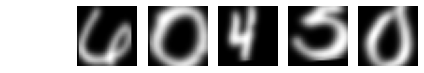

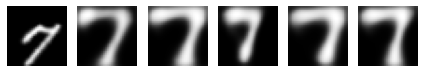

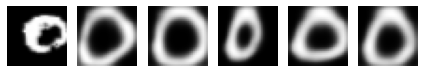

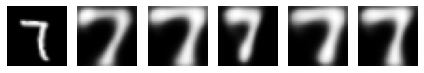

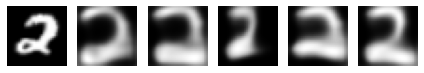

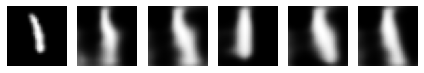

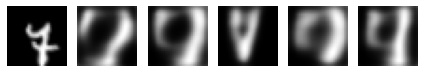

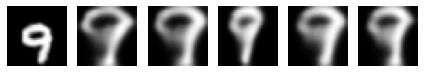

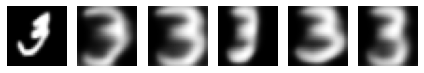

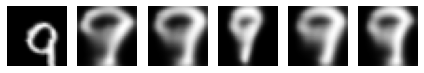

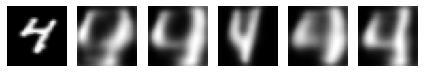

In [9]:
plot_target_cross_domain_swapping(model, source_train_loader, target_train_loader)

In [7]:
torch.save(model, "mnist_to_usps.pth")